In [297]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt

from graph import Graph
from article import Article
import random
import pandas as pd
import seaborn as sns
import mplcursors 
import numpy as np

## Part 1 : Graphs Creation at the Article, Category and Topic Level.

### 1.1 : Initialise empty graphs

In [298]:
cs_graph = Graph()
truth_graph = Graph()

### 1.2 : Read categories.tsv file to initialise the Vertices. $\\\\$

Populate the graph with the vertcies of each level (Articles, Categories and Topic).

In [299]:
cs_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=True)
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
0 in the articles graph,
0 in the categories graph,
0 in the topics graph.


### 1.3 : Read the paths_finished.tsv and paths_unfinished.tsv  to construct Edges in the Common Sence Graph $\\\\$

Populate the adjacency matrix with the edges for each of the 3 graphs.

In [300]:
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=True) 

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
50354 in the articles graph,
6530 in the categories graph,
208 in the topics graph.


In [301]:
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
57572 in the articles graph,
6931 in the categories graph,
208 in the topics graph.


### 1.4 : Read the links.tsv file to construct Edges in the Truth Graph $\\\\$ 

In [302]:
truth_graph.update_graph("data/links.tsv", mode='g', verbose=True)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
119769 in the articles graph,
8593 in the categories graph,
210 in the topics graph.


## Part 2 : Data Frame Creation at the Article, Category and Topic Level.

| Column name          | Description                                                                                                                                                                                       |   
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Topic           | The topic of the vertex (Not valid for the Topic df)                                                                                                                                    |
| Category            | The category of the vertex (Not valid for the Topic df nor the the Category Df)                                                                      |
| out_degree          | The number of different articles to which users went from this article      |
| in_degree          | The number of different articles from which users ended up in this article    |
| degree             | Sum of nb_unique_outgoing_edges and nb_unique_incoming_edges            |
| total_weight_out        | Sum of the weights of the outgoing edges     |
| total_weight_in        | Sum of the weights of the incoming edges      |
| total_weight        | Sum of the weights of the incoming and outgoing edges       |
| average_weight_out        | The average weight of an outgoing edge      |
| average_weight_in       | The average weight of an incoming edge     |
| average_weight       | The average weight of an incoming or outgoing edge      |
| nb_articles       |   The number of articles in the Vertex (Not valid for articles)    |
| nb_categories       | The number of categories contained in the Vertex (Not valid for Articles and Categories df)   |



In [303]:
def vertices_to_df(graph, level):
    assert level in graph.authorized_levels
    _, verteces = graph.levels_map[level]
    header =["Topic", "Category", "degree", "out_degree", "in_degree", "total_weight" ,"total_weight_out", "total_weight_in","average_weight_per_edge", "average_weight_out", "average_weight_in"]  
    if level == "categories":
        header.remove("Category")
        header.append("nb_articles")
    if level == "topics":
        header.remove("Topic")
        header.remove("Category")
        header.append("nb_categories")
        header.append("nb_articles")
    
    df = pd.DataFrame(columns=header)
    for vertex in verteces.values():
        nb_unique_outgoing_edges = vertex.get_nb_different_out_neighbours()
        nb_unique_incoming_edges = vertex.get_nb_different_in_neighbours()
        nb_unique_edges = nb_unique_outgoing_edges + nb_unique_incoming_edges
        
        if (nb_unique_edges != 0) :
            total_weight_out = vertex.get_total_out_weight()
            total_weight_in = vertex.get_total_in_weight()
            total_weight = total_weight_out + total_weight_in
            average_weight_out = round(total_weight_out/nb_unique_outgoing_edges, 2) if nb_unique_outgoing_edges != 0 else 0
            average_weight_in = round(total_weight_in/nb_unique_incoming_edges,2) if nb_unique_incoming_edges != 0 else 0
            average_weight_per_edge = round(total_weight/nb_unique_edges, 2)

            if level == "articles":
                df.loc[vertex.title] = [vertex.topic, vertex.category, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in]
                df["Topic"].astype("category")
                df["Category"].astype("category")
            elif level == "categories":
                df.loc[vertex.title]= [vertex.topic, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_articles()]
                df["Topic"].astype("category")
            else:
                df.loc[vertex.title]= [nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_categories(), vertex.get_nb_different_articles()]
    return df

### 2.1 : Create the Data Frame for the Common Sense Graphs

In [304]:
df_articles_cs = vertices_to_df(cs_graph, level="articles")
df_categrories_cs = vertices_to_df(cs_graph, level="categories")
df_topics_cs = vertices_to_df(cs_graph, level="topics")

In [305]:
df_articles_cs.sort_values(by=["out_degree"], ascending=False).head(5)

,Topic,Category,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in
United_States,Geography,North_American_Geography,1531,255,1276,23348,11557,11791,15.25,45.32,9.24
Africa,Geography,African_Geography,512,179,333,6677,3318,3359,13.04,18.54,10.09
United_Kingdom,Geography,Geography_of_Great_Britain,840,167,673,9819,4817,5002,11.69,28.84,7.43
England,Geography,Geography_of_Great_Britain,733,165,568,8140,3978,4162,11.11,24.11,7.33
Europe,Geography,European_Geography,847,147,700,10599,5285,5314,12.51,35.95,7.59


In [306]:
df_categrories_cs.sort_values(by=["out_degree"], ascending=False).head(5)

,Topic,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_articles
General_history,History,214,106,108,2665,1235,1430,12.45,11.65,13.24,80
European_Countries,Geography,227,105,122,4393,1423,2970,19.35,13.55,24.34,56
North_American_Geography,Geography,225,102,123,4264,1448,2816,18.95,14.20,22.89,103
Countries,Countries,219,101,118,5734,2401,3333,26.18,23.77,28.25,229
Geography_of_Great_Britain,Geography,221,101,120,3325,1275,2050,15.05,12.62,17.08,124


In [307]:
df_topics_cs.sort_values(by=["out_degree"], ascending=False).head(5)

,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_categories,nb_articles
History,28.0,14.0,14.0,7721.0,3827.0,3894.0,275.75,273.36,278.14,14.0,545.0
People,28.0,14.0,14.0,8691.0,5510.0,3181.0,310.39,393.57,227.21,20.0,708.0
Countries,28.0,14.0,14.0,5734.0,2401.0,3333.0,204.79,171.50,238.07,1.0,229.0
Geography,28.0,14.0,14.0,18549.0,7368.0,11181.0,662.46,526.29,798.64,21.0,1084.0
Business_Studies,28.0,14.0,14.0,1414.0,691.0,723.0,50.50,49.36,51.64,4.0,88.0


### 2.2 : Create the Data Frame for the Truth Graphs

In [308]:
df_articles_truth = vertices_to_df(truth_graph, level="articles")
df_categrories_truth = vertices_to_df(truth_graph, level="categories")
df_topics_truth = vertices_to_df(truth_graph, level="topics")

In [309]:
df_articles_truth.sort_values(by=["out_degree"], ascending=False).head(5)

,Topic,Category,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in
United_States,Geography,North_American_Geography,1845,294,1551,1845,294,1551,1.0,1.0,1.0
Driving_on_the_left_or_right,Design_and_Technology,Road_transport,255,255,0,255,255,0,1.0,1.0,0.0
List_of_countries,Geography,General_Geography,307,244,63,307,244,63,1.0,1.0,1.0
List_of_circulating_currencies,Business_Studies,Currency,244,236,8,244,236,8,1.0,1.0,1.0
List_of_sovereign_states,Geography,General_Geography,259,216,43,259,216,43,1.0,1.0,1.0


In [310]:
df_categrories_truth.sort_values(by=["out_degree"], ascending=False).head(5)

,Topic,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_articles
General_history,History,230,115,115,5623,2886,2737,24.45,25.10,23.80,80
Geography_of_Great_Britain,Geography,235,114,121,6912,2907,4005,29.41,25.50,33.10,124
Countries,Countries,233,113,120,15316,5120,10196,65.73,45.31,84.97,229
North_American_Geography,Geography,234,111,123,8025,3033,4992,34.29,27.32,40.59,103
European_Countries,Geography,231,109,122,11324,2991,8333,49.02,27.44,68.30,56


In [311]:
df_topics_truth.sort_values(by=["out_degree"], ascending=False).head(5)

,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_categories,nb_articles
History,28.0,14.0,14.0,16923.0,9546.0,7377.0,604.39,681.86,526.93,14.0,545.0
People,28.0,14.0,14.0,20074.0,13258.0,6816.0,716.93,947.00,486.86,20.0,708.0
Countries,28.0,14.0,14.0,15316.0,5120.0,10196.0,547.00,365.71,728.29,1.0,229.0
Geography,28.0,14.0,14.0,41381.0,16348.0,25033.0,1477.89,1167.71,1788.07,21.0,1084.0
Business_Studies,28.0,14.0,14.0,3478.0,1802.0,1676.0,124.21,128.71,119.71,4.0,88.0


In [312]:
df_topics_cs / df_topics_truth

,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_categories,nb_articles
History,1.000000,1.000000,1.000000,0.456243,0.400901,0.527857,0.456245,0.400903,0.527850,1.0,1.0
People,1.000000,1.000000,1.000000,0.432948,0.415598,0.466696,0.432943,0.415597,0.466684,1.0,1.0
Countries,1.000000,1.000000,1.000000,0.374380,0.468945,0.326893,0.374388,0.468951,0.326889,1.0,1.0
Geography,1.000000,1.000000,1.000000,0.448249,0.450697,0.446650,0.448247,0.450703,0.446649,1.0,1.0
Business_Studies,1.000000,1.000000,1.000000,0.406555,0.383463,0.431384,0.406570,0.383498,0.431376,1.0,1.0
Science,1.000000,1.000000,1.000000,0.546722,0.556085,0.534448,0.546730,0.556081,0.534453,1.0,1.0
Everyday_life,1.000000,1.000000,1.000000,0.517459,0.516714,0.518476,0.517476,0.516709,0.518492,1.0,1.0
Design_and_Technology,1.000000,1.000000,1.000000,0.457914,0.431798,0.509368,0.457887,0.431811,0.509344,1.0,1.0
Music,1.000000,1.000000,1.000000,0.488248,0.469088,0.531142,0.488184,0.469112,0.531121,1.0,1.0
IT,0.964286,0.928571,1.000000,0.728749,0.688000,0.765996,0.755817,0.740969,0.766061,1.0,1.0


## Part 3 : Plot the Topics Graph

In [313]:
def draw_graph (graph, df_topics):
    n = len(df_topics)
    color =['#445148', '#4a136c', '#502590', '#5636b3', '#5653b1',
            '#4e7a88', '#47a05f', '#40c736', '#ffbc3f', '#ffa426',
            '#ff8c0d', '#ff7504', '#ff5e0b', '#ff4812', '#ff3219']

    labels = list(graph.topics.keys())
    # map each category to a color
    color_map = {category: color[i] for i, category in enumerate(graph.topics.keys())}

    G1 = nx.DiGraph()
    
    for key, value in graph.matrix_topics.items():
        for key2, value2 in value.items():
                G1.add_edge(key,key2,weight=value2, color=color_map[key])


    color = []
    for node in G1.nodes(): 
        color.append(color_map[node])

    label_dict = {}
    for i in range(len(labels)):
        label_dict[labels[i]] = labels[i]


    edges = G1.edges()
    weights = [G1[u][v]['weight']/250 for u,v in edges]
    colors = [G1[u][v]['color'] for u,v in edges]

    nodePos = nx.circular_layout(G1)
    nodePos['People'] = [ -0.5, 0]
    nodePos['Citizenship'] = [0.5,0]
    nodePos['Geography'] = [0,0.1]
    nodePos['Science'] = [-0.5,0.5]
    nodePos['Everyday_life'] = [-0.75,0.25]
    nodePos['History'] = [0,0.5]
    nodePos['Countries'] = [0.3,0.3]
    nodePos['Design_and_Technology'] = [0,-0.3]
    nodePos['Language_and_literature'] = [-0.3,-0.3]
    nodePos['Religion'] = [0.1,-0.1]
    nodePos['Mathematics'] = [0,-0.4]
    nodePos['Art'] = [-0.5,-0.4]
    nodePos['IT'] = [-0.90,0]
    nodePos['Music'] = [0.5,-0.4]
    nodePos['Business_Studies'] = [0.3,-0.3]

    size = [df_topics.loc[t_name].nb_articles*25 for t_name in nx.nodes(G1)]

    nx.draw_networkx(G1,node_size = size,pos = nodePos,node_color = color,labels=label_dict, width= weights, edge_color=colors, arrows=True, arrowstyle='->',arrowsize=20, font_size=12, font_color='black', font_weight='bold', font_family='sans-serif', alpha=1.0, bbox=None, ax=None, with_labels=True, edgecolors='black', node_shape='o', connectionstyle='arc3, rad=0.1', min_source_margin=0.05)

### 3.1 : Plot the Common Sence and truth Topics Graph

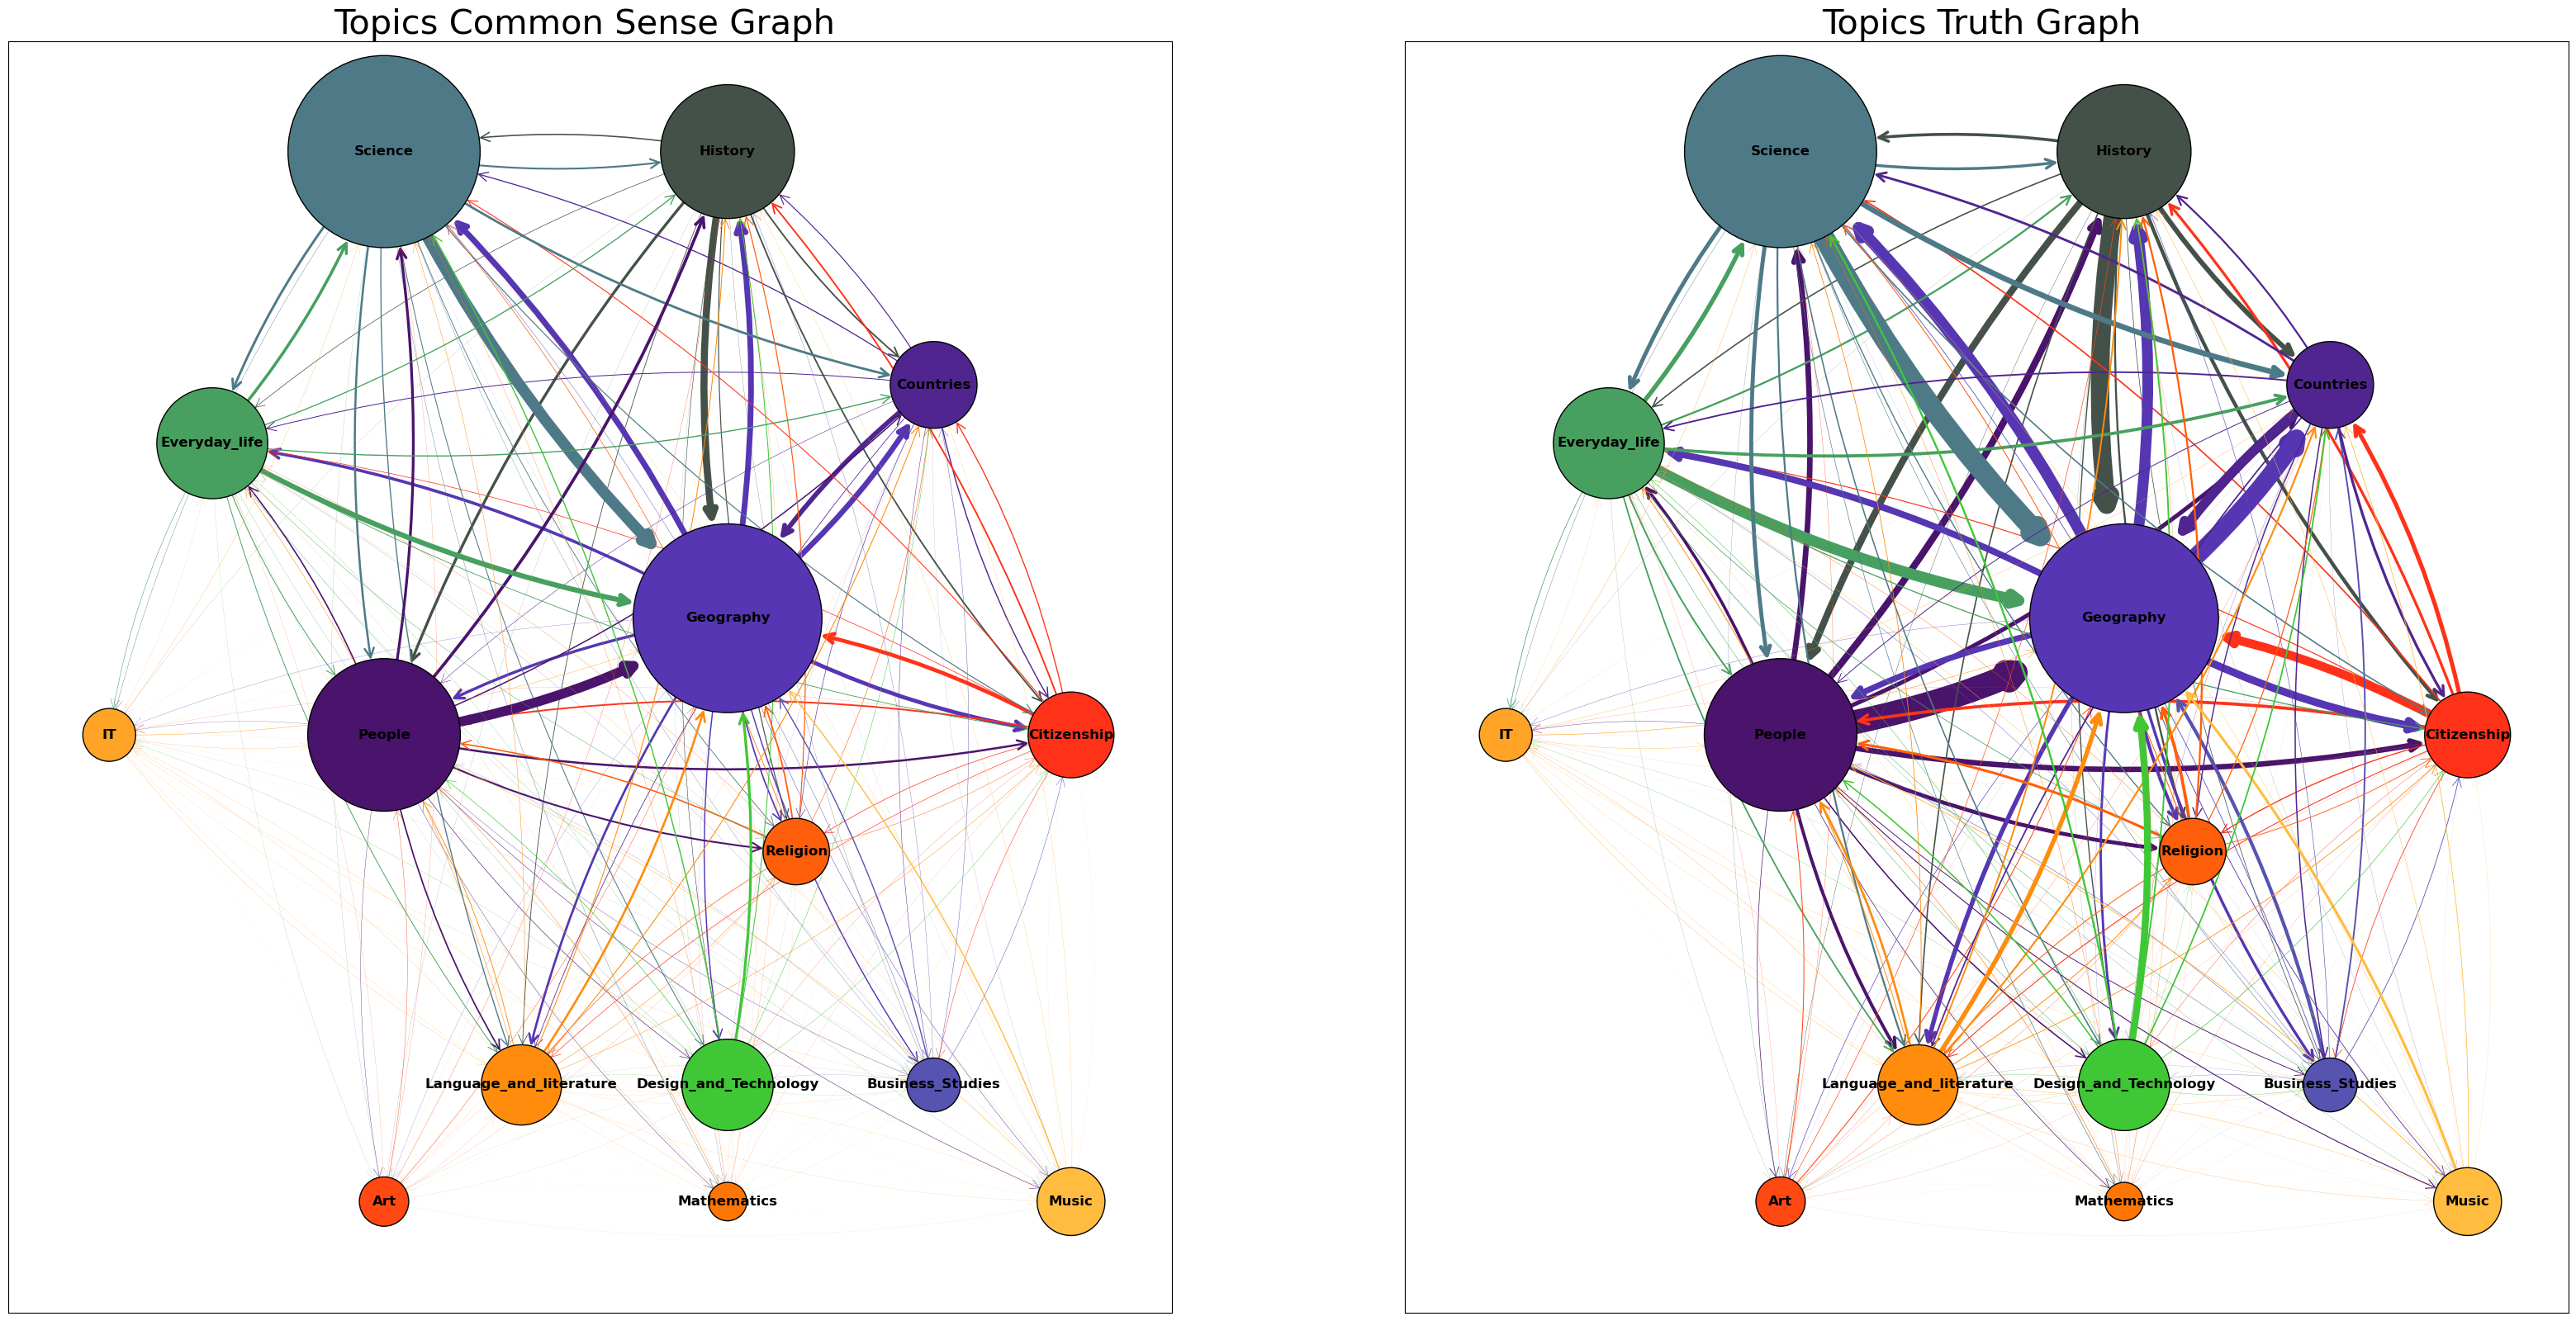

In [314]:
plt.figure(figsize=(40,20))

#add title in each graph


plt.subplot(121)
plt.title("Topics Common Sense Graph ", fontsize=30)
draw_graph(cs_graph, df_topics_cs)

plt.subplot(122)
plt.title("Topics Truth Graph ", fontsize=30)
draw_graph(truth_graph, df_topics_truth)
plt.show()

On the left we can see the common sense graph and on the right the truth graph.$\\\\$
We notice that the truth graph is much more dense than the common sense graph.$\\\\$
The edges are thicker in the truth graph than in the common sense graph.$\\\\$
This is due to the fact that not all possible direct path from one Topic to another have been explored by the users.$\\\\$
This result can be assassed when comparing the topics data frames.


## Part 4 : Initial Analysis


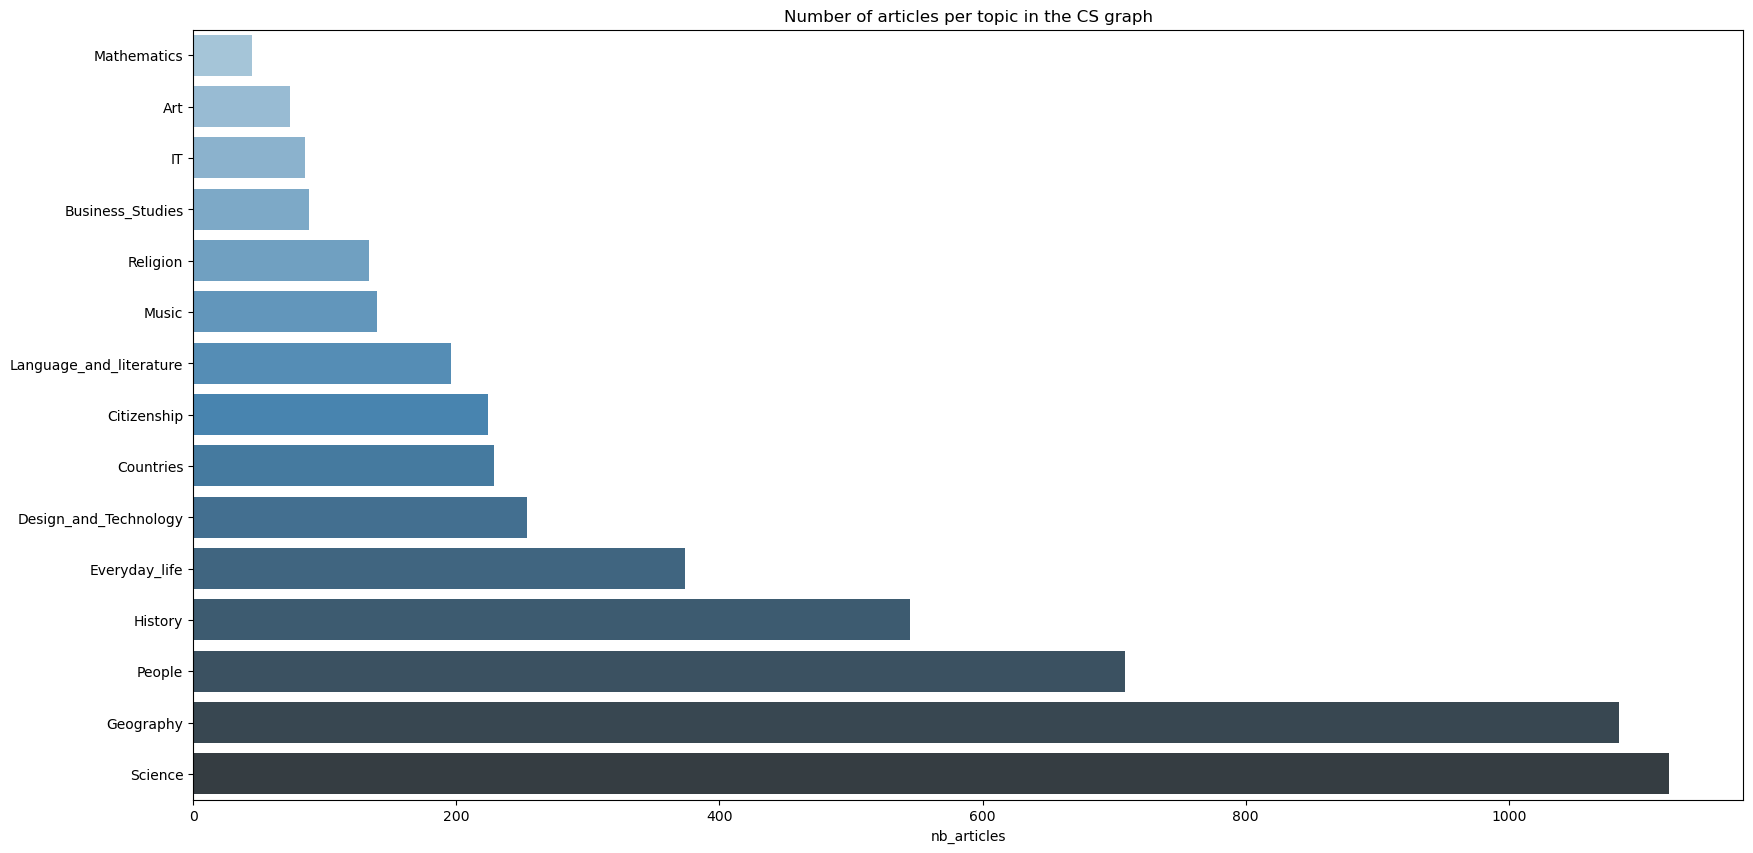

In [315]:
# plot the number of articles per topic with sns ordred by the number of articles
plt.figure(figsize=(20,10))
sns.barplot(x=df_topics_cs.nb_articles, y=df_topics_cs.index, data=df_topics_cs, order=df_topics_cs.sort_values(by=["nb_articles"], ascending=True).index, palette="Blues_d")
plt.title("Number of articles per topic in the CS graph")
plt.show()

We can see that the number of articles is nos uniformly distributed according to the Topics

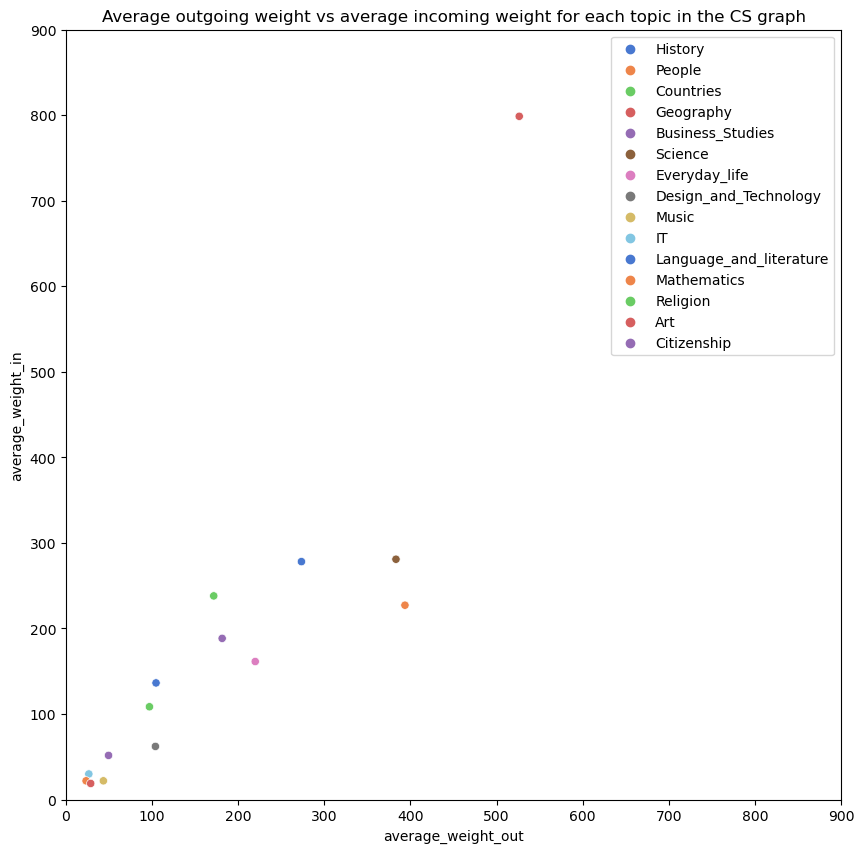

In [316]:
# plot the topics using average outgoing weight and average incoming weight
plt.figure(figsize=(10,10))
# x and y axis have the same scale
plt.xlim(0, 900)
plt.ylim(0, 900)

# multicolor palette sns
sns.set_palette("muted")

sns.scatterplot(x=df_topics_cs.average_weight_out, y=df_topics_cs.average_weight_in, data=df_topics_cs, hue=df_topics_cs.index, palette="muted")
plt.title("Average outgoing weight vs average incoming weight for each topic in the CS graph")
plt.show()

# Part 5 : Regression analysis

understand based on which parameter  (position in page , topics related .. . ) a link will be explored


In [317]:
dict_links = {}
prev_article = ""
with open('data/links.tsv') as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for j , line in enumerate(tsv_file):
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else : 
                    if line[0] != prev_article:
                        i= 1 
                        print('new article : ', line[0])
       
                    topic1 = truth_graph.get_topic_of_article(line[0])
                    topic2 = truth_graph.get_topic_of_article(line[1])
                    if topic1 == None or topic2 == None:
                         dict_links[j] = [line[0],line[1],i,None]
                    else:
                        dict_links[j] = [line[0],line[1],i,topic1+topic2]
                    i += 1
                    prev_article = line[0]

new article :  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
new article :  %C3%85land
new article :  %C3%89douard_Manet
new article :  %C3%89ire
new article :  %C3%93engus_I_of_the_Picts
new article :  %E2%82%AC2_commemorative_coins
new article :  10th_century
new article :  11th_century
new article :  12th_century
new article :  13th_century
new article :  14th_century
new article :  15th_Marine_Expeditionary_Unit
new article :  15th_century
new article :  16_Cygni
new article :  16_Cygni_Bb
new article :  16th_century
new article :  1755_Lisbon_earthquake
new article :  17th_century
new article :  1896_Summer_Olympics
new article :  18th_century
new article :  1928_Okeechobee_Hurricane
new article :  1973_oil_crisis
new article :  1980_eruption_of_Mount_St._Helens
new article :  1997_Pacific_hurricane_season
new article :  19th_century
new article :  1_Ceres
new article :  1st_century
new article :  1st_century_BC
new article :  2-6-0
new article :  2-8-0
new article :  2003_Atlantic_hurricane_s

In [318]:
links_df = pd.DataFrame.from_dict(dict_links, orient='index', columns=['article_from', 'article_to', 'position', 'topics_related'])

In [319]:
links_df.sample(10)

,article_from,article_to,position,topics_related
64605,List_of_Asian_countries,Qatar,45,GeographyGeography
77114,National_parks_of_England_and_Wales,Snowdonia_National_Park,18,GeographyGeography
40556,Forth_Bridge_%28railway%29,Alan_Turing,2,Design_and_TechnologyPeople
110966,Turkey,Agriculture,5,GeographyEveryday_life
109357,Tottenham_Hotspur_F.C.,20th_century,1,Everyday_lifeHistory
92167,Riesling,Romania,9,Everyday_lifeGeography
29131,Dance,Animal,4,Everyday_lifeScience
52561,Hubble_Space_Telescope,United_States_House_of_Representatives,40,ScienceCitizenship
3812,African_Union,French_language,34,CitizenshipLanguage_and_literature
93986,Russia,People%27s_Republic_of_China,75,GeographyCountries


In [320]:
links_df['weight'] = links_df.apply(lambda row: cs_graph.get_weight_of_link(row['article_from'],row['article_to']),axis=1)

In [321]:
links_df.sample(10)

,article_from,article_to,position,topics_related,weight
64219,Lincoln_Town_Car,Lincoln_%28automobile%29,3,Design_and_TechnologyDesign_and_Technology,0
26981,Copper,Zinc,67,ScienceScience,7
26172,Communism,World_War_I,57,CitizenshipHistory,12
119666,Zinc,Mohs_scale_of_mineral_hardness,26,ScienceGeography,1
100178,Sony,Electronics,4,Business_StudiesDesign_and_Technology,53
47041,Guild,Trade_union,22,Business_StudiesCitizenship,2
43151,George_Eliot,20th_century,2,PeopleHistory,2
29458,David_Cameron,Human_rights,22,PeopleCitizenship,0
37582,European_Union,Age_of_Enlightenment,1,CitizenshipReligion,1
100173,Sonic_the_Hedgehog_%28character%29,Theodore_Roosevelt,24,Everyday_lifePeople,1


In [322]:
links_df[links_df['weight']== 674]

,article_from,article_to,position,topics_related,weight
7140,Animal,Mammal,18,ScienceScience,674


/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_4176/1013077105.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=links_df.position, y=links_df.weight, data=links_df, hue=None, palette="muted")


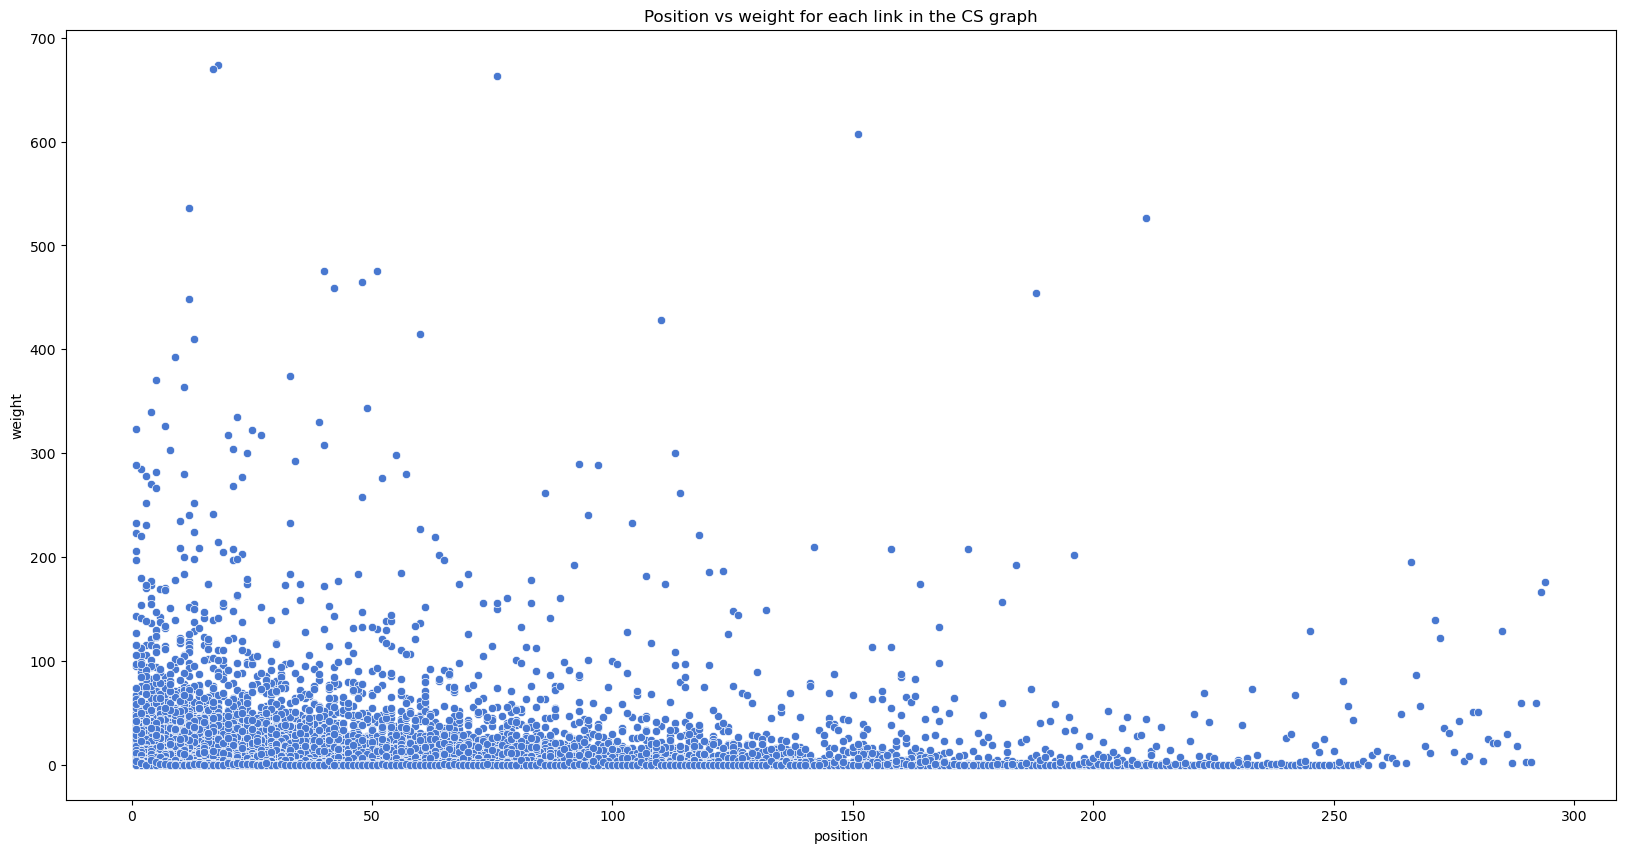

In [323]:
# plot position vs weight for each link
plt.figure(figsize=(20,10))
sns.scatterplot(x=links_df.position, y=links_df.weight, data=links_df, hue=None, palette="muted")
plt.title("Position vs weight for each link in the CS graph")
plt.show()

In [324]:
#compute pearson correlation between position and weight
links_df[['position','weight']].corr(method='spearman')

,position,weight
position,1.000000,-0.016224
weight,-0.016224,1.000000


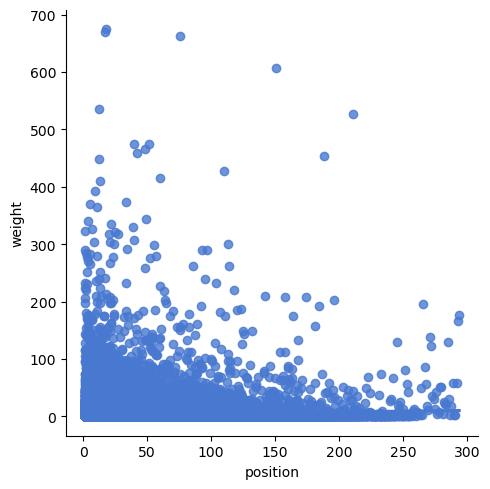

In [325]:
sns.lmplot(x ='position', y ='weight', data = links_df)



# Get right position 

scraping the html pages of each article 



# Part 1 : 
Assumption  : take only first occurence of each link to compute position 

In [326]:
from bs4 import BeautifulSoup
from urllib.parse import unquote


In [327]:
positions = {}

In [328]:
html_base_path = 'data/wpcd/wp/'

In [329]:
def get_position(article1, article2):#get links with href
    links = []
    if article1 in positions:
        if len(positions[article1]) > 0:
            try:
                return   positions[article1].index(article2)
            except:
                return None

        return None
    #encode artile1 to utf8
    try : 

        with open(html_base_path+'{}/{}.htm'.format(article1[0],article1)) as fp:
            soup = BeautifulSoup(fp, 'html.parser')


     

    except : 
        print('No')
        positions[article1] = []
        return None

    for link in soup.findAll('a'):
        href = link.get('href')
        if  href !=None and href.startswith("../../wp/"):
            article = href.split("/")[-1].split(".")[0]
            
            links.append(article)

        #keep only links in graph

    only = [link for link in links if link in truth_graph.matrix_articles[article1]]

    #remove all occurences of duplicates with conserving order
    only = list(dict.fromkeys(only))
    positions[article1] = only
    # get index of article2 in only
    try :
        index = only.index(article2)
    except :
        index = None
        
    print(len(positions)/truth_graph.nb_vertices("articles"))
    return index
   
 


In [330]:
links_df['position2'] = links_df.apply(lambda row: get_position(row['article_from'],row['article_to']),axis=1)

0.00021743857360295715
0.0004348771472059143
0.0006523157208088715
0.0008697542944118286
0.0010871928680147858
0.001304631441617743
0.0015220700152207
0.0017395085888236572
0.0019569471624266144
0.0021743857360295715
0.0023918243096325287
0.002609262883235486
0.002826701456838443
0.0030441400304414
0.0032615786040443573
0.0034790171776473144
0.0036964557512502716
0.003913894324853229
0.004131332898456186
0.004348771472059143
0.0045662100456621
0.004783648619265057
0.0050010871928680145
0.005218525766470972
0.005435964340073929
0.005653402913676886
0.005870841487279843
0.0060882800608828
0.006305718634485757
0.006523157208088715
0.006740595781691672
0.006958034355294629
0.007175472928897586
0.007392911502500543
0.0076103500761035
0.007827788649706457
0.008045227223309415
0.008262665796912372
0.008480104370515329
0.008697542944118286
0.008914981517721243
0.0091324200913242
0.009349858664927158
0.009567297238530115
0.009784735812133072
0.010002174385736029
0.010219612959338986
0.010437051

In [331]:
links_df.sample(10)

,article_from,article_to,position,topics_related,weight,position2
40423,Formic_acid,Acetic_acid,1,ScienceScience,3,0.0
6120,Ammonia,Tobacco,53,ScienceScience,1,36.0
2452,Abadan,Ptolemy,9,GeographyPeople,0,2.0
104893,TGV,Netherlands,24,Design_and_TechnologyGeography,0,8.0
61923,Laika,Vladimir_Lenin,24,SciencePeople,0,18.0
9387,Arsenic,Germanium,17,ScienceScience,0,0.0
86989,Polish-Lithuanian_Commonwealth,Lithuania,43,HistoryGeography,0,9.0
46713,Gregorian_chant,Christianity,7,MusicReligion,1,2.0
62611,Lavender,Mediterranean_Sea,11,ScienceGeography,1,3.0
57568,Jakarta,Black_pepper,5,GeographyEveryday_life,1,9.0


In [332]:
# get percentage of Nan values in position2
links_df['position2'].isna().sum()/len(links_df)

0.03959727064947198

/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_4176/710487656.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=links_df.position2, y=links_df.weight, data=links_df, hue=None, palette="muted")


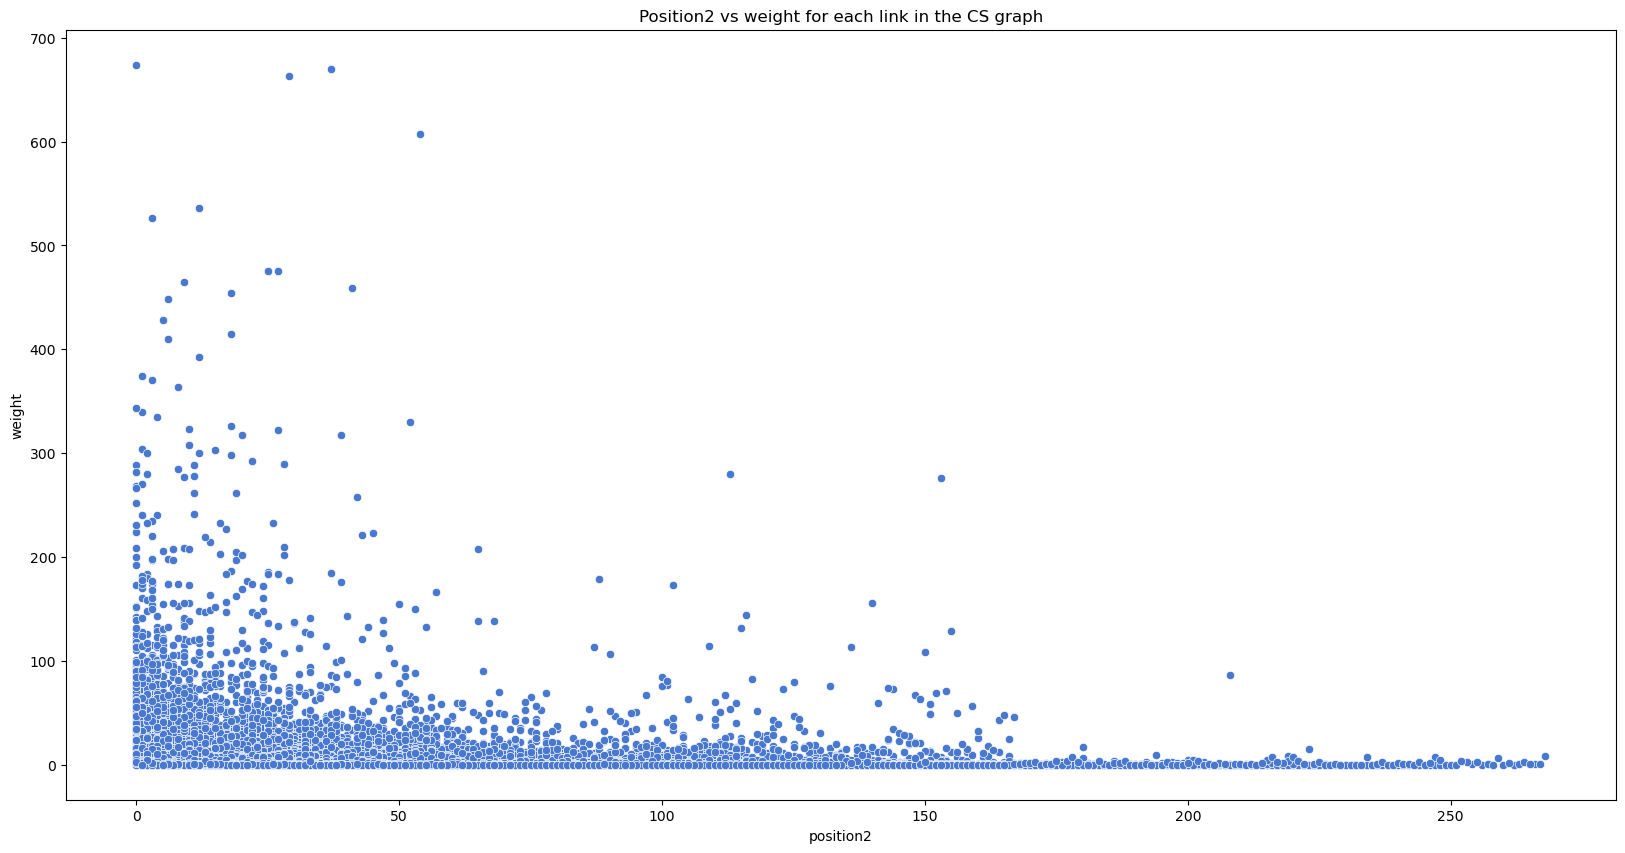

In [333]:
#plot position2 vs weight for each link
plt.figure(figsize=(20,10))
sns.scatterplot(x=links_df.position2, y=links_df.weight, data=links_df, hue=None, palette="muted")
plt.title("Position2 vs weight for each link in the CS graph")
plt.show()

In [334]:
#compute pearson correlation between position2 and weight
links_df[['position2','weight']].corr(method='spearman')


,position2,weight
position2,1.000000,-0.189679
weight,-0.189679,1.000000


In [335]:
#get number of links for each article_from
links_df['nb_links'] = links_df.groupby('article_from')['article_from'].transform('count')

In [336]:
#check if any position2 is bigger than nb_links
links_df[links_df['position2'] > links_df['nb_links']]

,article_from,article_to,position,topics_related,weight,position2,nb_links


In [337]:

links_df['relative_position'] = links_df.apply(lambda row: row['position2']/row['nb_links'],axis=1)

In [338]:
#format relative_position to 2 decimals * 100
links_df['relative_position'] = links_df['relative_position'].apply(lambda x: round(x,2)*100)

In [339]:
links_df.drop(columns=['position'], inplace=True)

In [340]:
#rename position2 to position
links_df.rename(columns={'position2': 'position'}, inplace=True)


In [341]:
#drop links with Nan values in position
links_df.dropna(subset=['position'], inplace=True)
#change positoin to int
links_df['position'] = links_df['position'].astype(int)

In [342]:
links_df.sample(10)

,article_from,article_to,topics_related,weight,position,nb_links,relative_position
60507,Karl_Marx,Political_philosophy,PeopleReligion,5,3,63,5.0
45230,God,Augustine_of_Hippo,ReligionPeople,0,22,36,61.0
56273,Iron_Maiden,Jerusalem,MusicGeography,1,8,12,67.0
52246,Horse,Berlin,ScienceGeography,1,33,65,51.0
32713,Durian,Papua_New_Guinea,Everyday_lifeGeography,0,21,33,64.0
81592,Ordination_of_women,Vietnam,ReligionCountries,0,34,38,89.0
63168,Leicester,Kenya,GeographyCountries,1,24,44,55.0
110685,Tsunami,Buddha,GeographyPeople,2,13,57,23.0
52389,House_of_Lords,Parliament_of_the_United_Kingdom,CitizenshipCitizenship,8,0,25,0.0
11759,BBC,United_States,Everyday_lifeGeography,3,31,40,78.0


/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_4176/3062402634.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=links_df.relative_position, y=links_df.weight, data=links_df, hue=None, palette="muted")


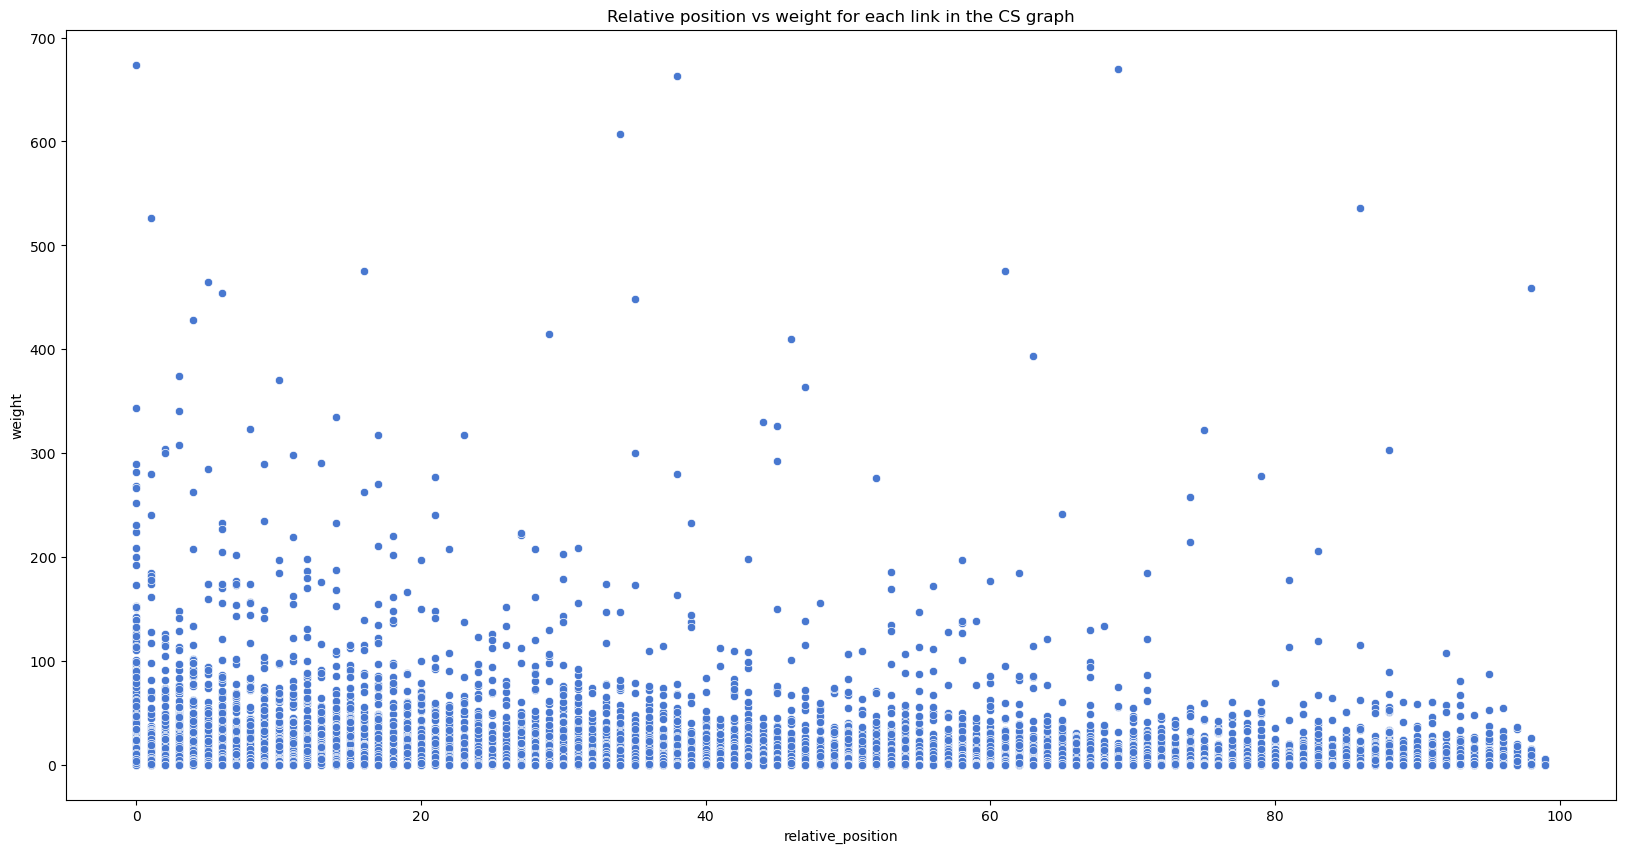

In [343]:
#plot relative_position vs weight for each link
plt.figure(figsize=(20,10))
sns.scatterplot(x=links_df.relative_position, y=links_df.weight, data=links_df, hue=None, palette="muted")  
plt.title("Relative position vs weight for each link in the CS graph")
plt.show()

In [344]:
# compute spearman correlation between relative_position and weight
links_df[['relative_position','weight']].corr(method='spearman')

,relative_position,weight
relative_position,1.000000,-0.211872
weight,-0.211872,1.000000


In [345]:
# get average weight for each relative_position
links_df.groupby('relative_position')['weight'].mean()


relative_position
0.0      6.264706
1.0     16.923358
2.0      8.341207
3.0      7.508560
4.0      6.696445
          ...    
95.0     1.727532
96.0     1.393939
97.0     1.595568
98.0     4.986667
99.0     1.321429
Name: weight, Length: 100, dtype: float64

/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_4176/1820575563.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=links_df.relative_position, y=links_df.weight, data=links_df, hue=None, palette="muted")


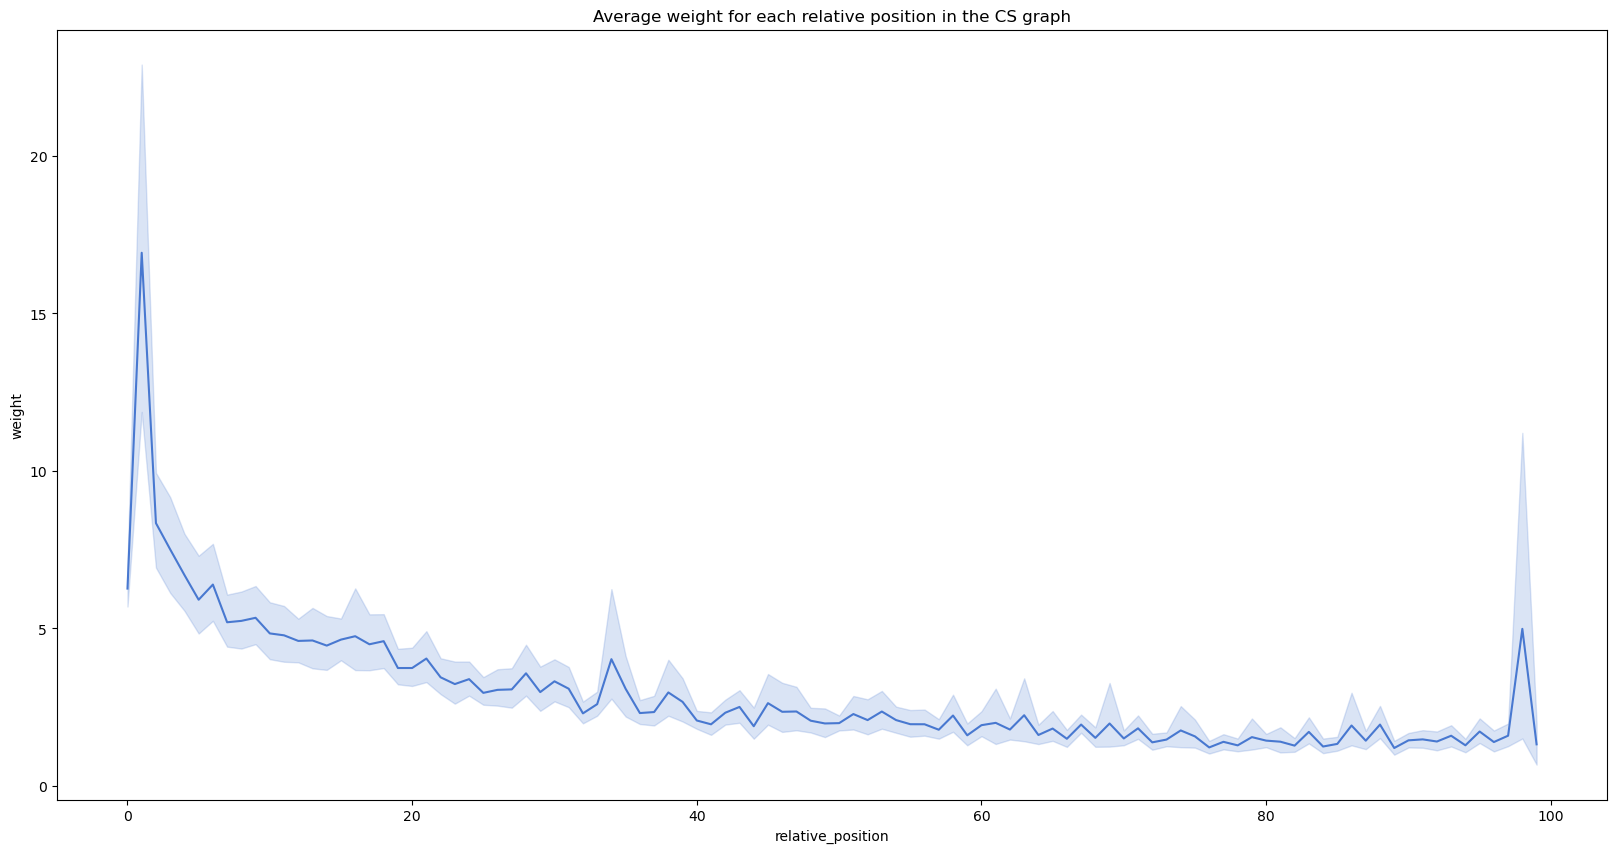

In [346]:
#plot average weight for each relative_position
plt.figure(figsize=(20,10))
sns.lineplot(x=links_df.relative_position, y=links_df.weight, data=links_df, hue=None, palette="muted")
plt.title("Average weight for each relative position in the CS graph")
plt.show()


In [347]:
len(links_df)

115135

In [348]:
positions= {}

#Part 2 
return -1 if it occurs multiple times (to study the effect of the presence of a link multiple times )

In [349]:
def get_position_in_array( array, string):
    # return -1 if the link occurs multiple times
    count = 0
    for i in array:
        if i == string:
            count += 1
    
    if count > 1 :
        return -1
    else:
        only = list(dict.fromkeys(array))
        return only.index(string)



In [350]:
def get_position_duplicates(article1, article2):#get links with href
    links = []
    if article1 in positions:
        if len(positions[article1]) > 0:
            try:
                return   get_position_in_array(positions[article1],article2)
            except:
                return None

        return None
    #encode artile1 to utf8
    try : 


        with open(html_base_path+'{}/{}.htm'.format(article1[0],article1)) as fp:
            soup = BeautifulSoup(fp, 'html.parser')

     

    except : 
        print('No')
        positions[article1] = []
        return None

    for link in soup.findAll('a'):
        href = link.get('href')
        if  href !=None and href.startswith("../../wp/"):
            article = href.split("/")[-1].split(".")[0]
            
            links.append(article)

        #keep only links in graph

    only = [link for link in links if link in truth_graph.matrix_articles[article1]]
   
  

    positions[article1] = only
    # get index of article2 in only
    try :
       
        index = get_position_in_array(positions[article1],article2)

    except :
        index = None
        
    print(len(positions)/truth_graph.nb_vertices("articles"))
    return index
   
 


In [351]:
links_df['position_duplicates'] = links_df.apply(lambda row: get_position_duplicates(row['article_from'],row['article_to']),axis=1)

0.00021743857360295715
0.0004348771472059143
0.0006523157208088715
0.0008697542944118286
0.0010871928680147858
0.001304631441617743
0.0015220700152207
0.0017395085888236572
0.0019569471624266144
0.0021743857360295715
0.0023918243096325287
0.002609262883235486
0.002826701456838443
0.0030441400304414
0.0032615786040443573
0.0034790171776473144
0.0036964557512502716
0.003913894324853229
0.004131332898456186
0.004348771472059143
0.0045662100456621
0.004783648619265057
0.0050010871928680145
0.005218525766470972
0.005435964340073929
0.005653402913676886
0.005870841487279843
0.0060882800608828
0.006305718634485757
0.006523157208088715
0.006740595781691672
0.006958034355294629
0.007175472928897586
0.007392911502500543
0.0076103500761035
0.007827788649706457
0.008045227223309415
0.008262665796912372
0.008480104370515329
0.008697542944118286
0.008914981517721243
0.0091324200913242
0.009349858664927158
0.009567297238530115
0.009784735812133072
0.010002174385736029
0.010219612959338986
0.010437051

In [352]:
links_df.sample(10)

,article_from,article_to,topics_related,weight,position,nb_links,relative_position,position_duplicates
79328,Noam_Chomsky,Dutch_language,Language_and_literatureLanguage_and_literature,0,13,29,45.0,13
5469,Alphabet,Hammurabi,Language_and_literatureHistory,1,11,14,79.0,11
109756,Transit_of_Venus,1st_century_BC,ScienceHistory,0,28,33,85.0,28
96622,Scramble_for_Africa,Egypt,HistoryCountries,0,30,134,22.0,-1
88857,Protactinium,Plutonium,ScienceScience,0,18,20,90.0,18
19921,Calligraphy,China,ArtCountries,1,14,34,41.0,14
51810,Holkham_Hall,England,Design_and_TechnologyGeography,2,1,15,7.0,1
106526,The_Cantos,Byzantine_Empire,Language_and_literatureHistory,0,76,86,88.0,76
19985,Calvin_and_Hobbes,Santa_Claus,Everyday_lifeEveryday_life,0,11,13,85.0,11
80662,Oceanography,Monaco,GeographyGeography,0,19,23,83.0,19


In [353]:
# get percentage of Nan values in position_duplicates
links_df['position_duplicates'].isna().sum()/len(links_df)


0.0

In [354]:
#get percentage of -1 values in position_duplicates
links_df[links_df['position_duplicates'] == -1].shape[0]/len(links_df)


0.22629956138446172

In [355]:
# relative position with duplicates
links_df['relative_position_duplicates'] = links_df.apply(lambda row: row['position_duplicates']/row['nb_links'],axis=1)


/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_4176/1666438297.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=links_df.relative_position_duplicates, y=links_df.weight, data=links_df, hue=None, palette="muted")


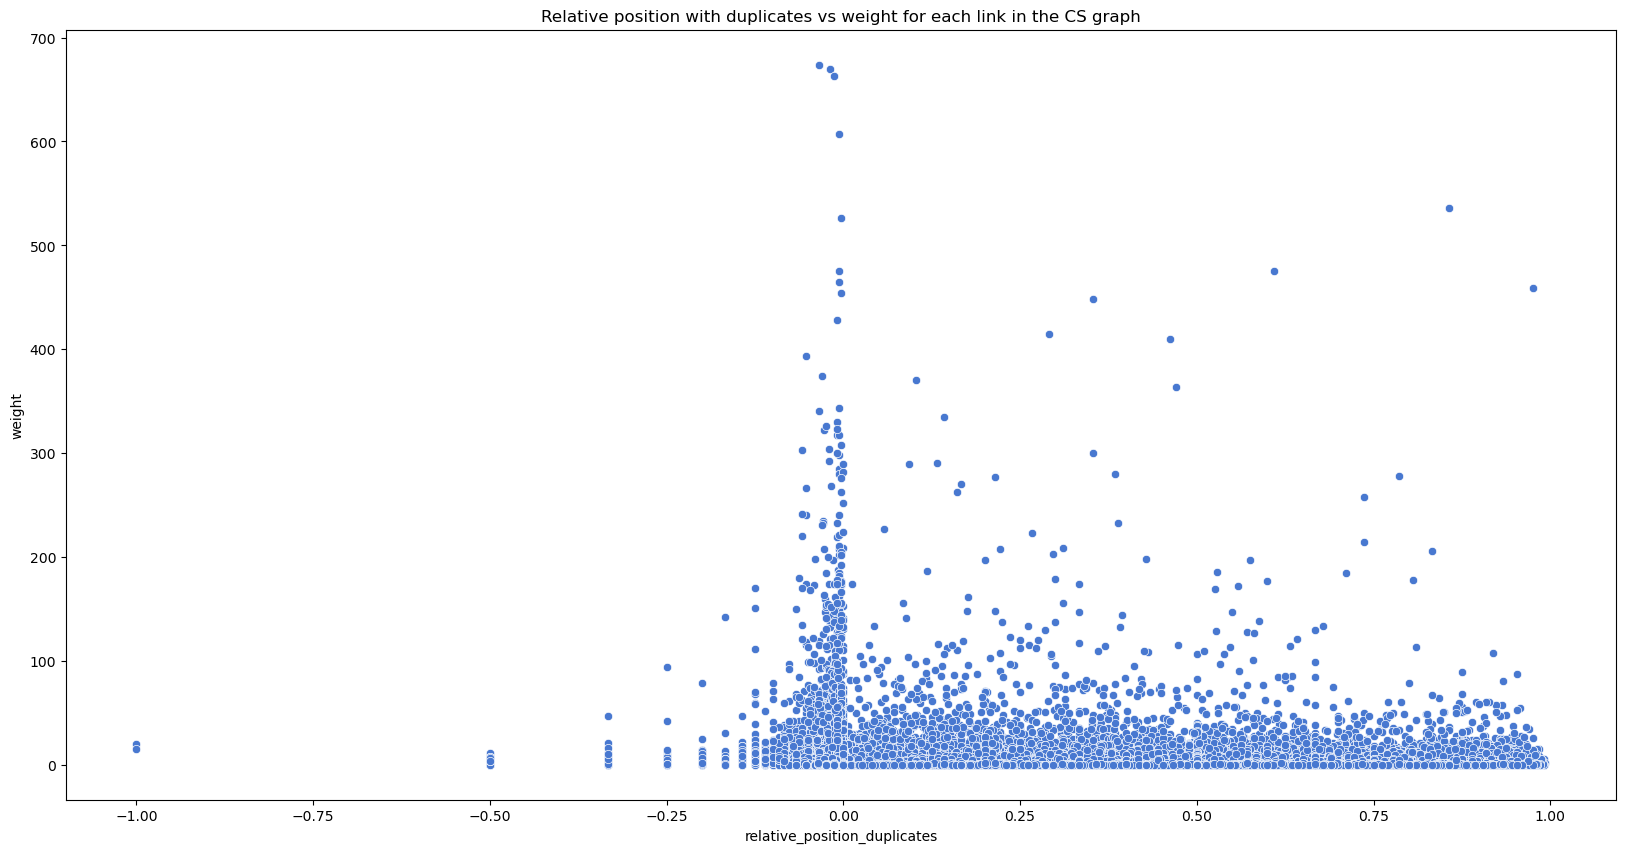

In [356]:
# plot relative_position_duplicates vs weight for each link
plt.figure(figsize=(20,10))
sns.scatterplot(x=links_df.relative_position_duplicates, y=links_df.weight, data=links_df, hue=None, palette="muted")
plt.title("Relative position with duplicates vs weight for each link in the CS graph")
plt.show()


In [357]:
# format relative_position_duplicates to 2 decimals * 100
links_df['relative_position_duplicates'] = links_df['relative_position_duplicates'].apply(lambda x: round(x,2)*100)

/var/folders/zp/t_7t2xyj4n760sxfr2jkq6z40000gn/T/ipykernel_4176/2789995677.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=links_df.relative_position_duplicates, y=links_df.weight, data=links_df, hue=None, palette="muted")


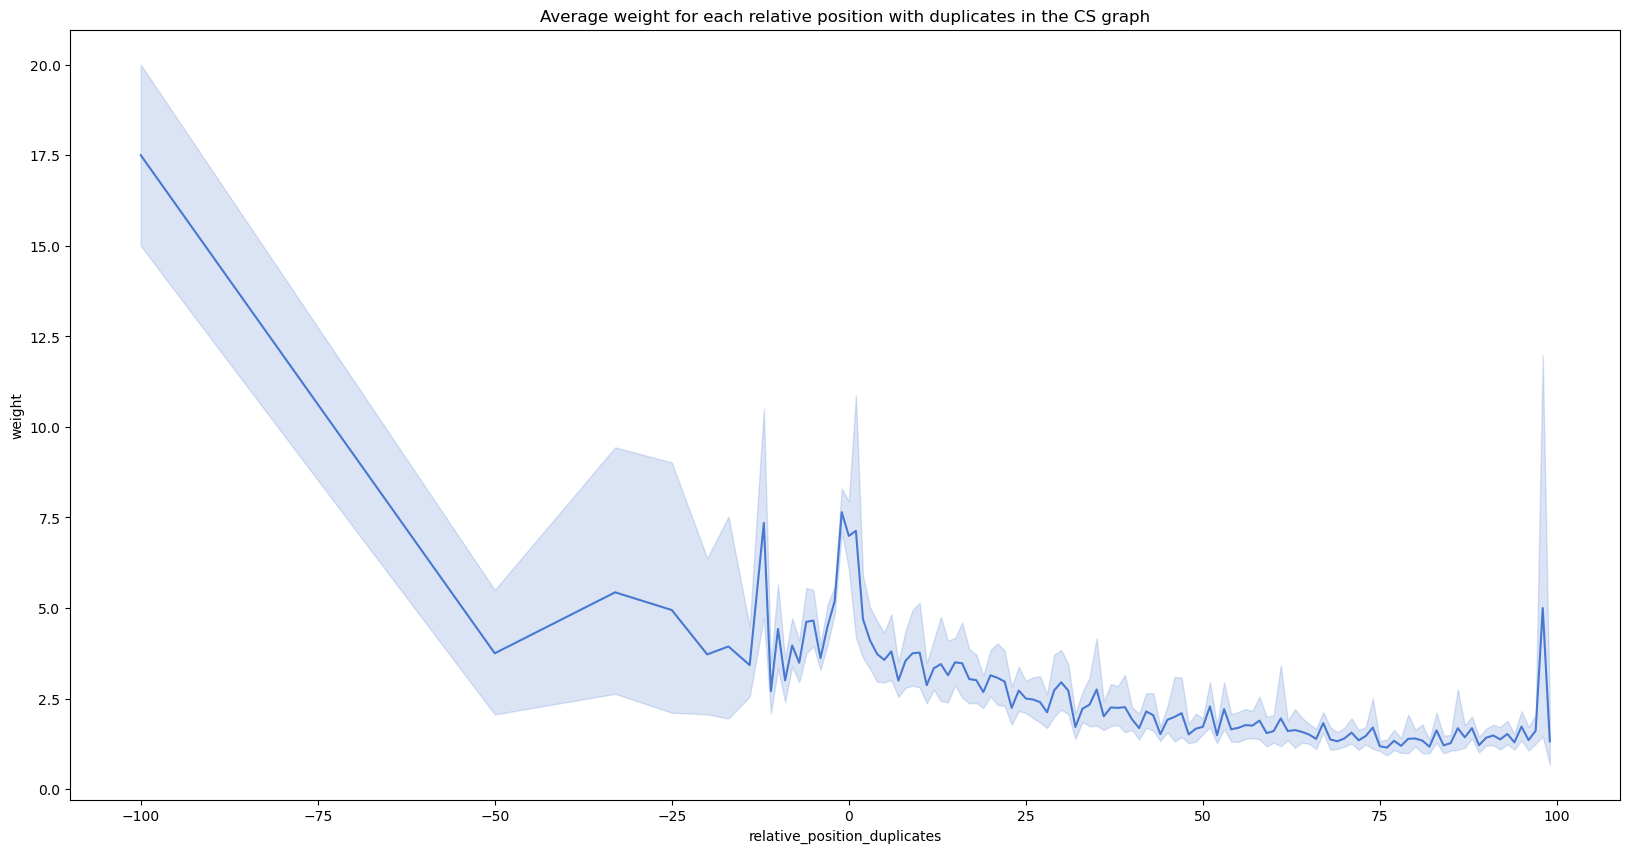

In [358]:
# plot average weight for each relative_position_duplicates
plt.figure(figsize=(20,10))
sns.lineplot(x=links_df.relative_position_duplicates, y=links_df.weight, data=links_df, hue=None, palette="muted")
plt.title("Average weight for each relative position with duplicates in the CS graph")
plt.show()
